In [18]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline
#pd.set_option("display.max_colwidth", 200)
from IPython.display import display

In [19]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

In [14]:
df =pd.read_csv('master_161208.csv')

In [6]:
df.columns.tolist()

['Unnamed: 0',
 'row_id',
 'icustay_id',
 'hadm_id',
 'subject_id',
 'age_at_intime',
 'gender',
 'height',
 'weight',
 'bmi',
 'ethnicity',
 'insurance',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascular',
 'ex_hypertension',
 'ex_paralysis',
 'ex_other_neurological',
 'ex_chronic_pulmonary',
 'ex_diabetes_uncomplicated',
 'ex_diabetes_complicated',
 'ex_hypothyroidism',
 'ex_renal_failure',
 'ex_liver_disease',
 'ex_peptic_ulcer',
 'ex_aids',
 'ex_lymphoma',
 'ex_metastatic_cancer',
 'ex_solid_tumor',
 'ex_rheumatoid_arthritis',
 'ex_coagulopathy',
 'ex_obesity',
 'ex_weight_loss',
 'ex_fluid_electrolyte',
 'ex_blood_loss_anemia',
 'ex_deficiency_anemias',
 'ex_alcohol_abuse',
 'ex_drug_abuse',
 'ex_psychoses',
 'ex_depression',
 'apsiii',
 'apsiii_prob',
 'apsiii_creatinine_score',
 'admittime',
 'dischtime',
 'intime',
 'outtime',
 'dod',
 'survived_icustay',
 'survived_hadm',
 'ed_chartdate',
 

In [7]:
# districution of first care unit in filtered list (patients with icu-echo), we are definitely selecting out more cardiac surgery patients
df.groupby(['ea_first_careunit']).size()

ea_first_careunit
CCU        87
CSRU     1365
MICU      404
SICU      125
TSICU      70
dtype: int64

In [74]:
#df.groupby(['ea_lv_systolic', 'ea_first_careunit']).size()

In [9]:
sql = """
SELECT *
  FROM mimiciii.icustays
  """
icustays = pd.read_sql_query(sql, conn)

In [24]:
# distribution of first care unit in all mimic patients. ps_vaso, diag_xc
icustays.groupby(['first_careunit']).size()

first_careunit
CCU       7726
CSRU      9312
MICU     21088
NICU      8100
SICU      8891
TSICU     6415
dtype: int64

In [37]:
icustays.columns.tolist()

['row_id',
 'subject_id',
 'hadm_id',
 'icustay_id',
 'dbsource',
 'first_careunit',
 'last_careunit',
 'first_wardid',
 'last_wardid',
 'intime',
 'outtime',
 'los']

In [38]:
#table.groupby('YEARMONTH').CLIENTCODE.nunique()
icustays.groupby('first_careunit')._id.nunique()

first_careunit
CCU       7726
CSRU      9312
MICU     21088
NICU      8100
SICU      8891
TSICU     6415
Name: icustay_id, dtype: int64

In [11]:
# MICU vs CSRU mortality and EF
day30_mortality = df.ea_days_after_discharge_death <= 30
#sns.barplot(x="ea_lv_systolic", y="day30_mortality", hue ="ea_first_careunit", data=df)

In [ ]:
# look back at consort diagram... where should we apply MICU filter?  instead of distributive shock filter??

In [15]:
sql = """
SELECT *
  FROM mimiciii.echo_features
  """
echo_features = pd.read_sql_query(sql, conn)

In [104]:
echo_features.groupby(['ea_first_careunit']).size()

ea_first_careunit
CCU      6202
CSRU     6084
MICU     7014
SICU     2254
TSICU    1194
dtype: int64

In [103]:
echo_features[echo_features['ps_vaso']==True].groupby(['ea_first_careunit']).size()

ea_first_careunit
CCU      2054
CSRU     4489
MICU     2663
SICU      942
TSICU     567
dtype: int64

In [105]:
echo_features[echo_features['diag_xc']==False].groupby(['ea_first_careunit']).size()

ea_first_careunit
CCU       602
CSRU     2155
MICU     2239
SICU      687
TSICU     375
dtype: int64

In [106]:
echo_features[(echo_features['ps_vaso']==True) & (echo_features['diag_xc']==False)].groupby(['ea_first_careunit']).size()

ea_first_careunit
CCU       159
CSRU     1587
MICU      797
SICU      274
TSICU     155
dtype: int64

In [108]:
echo_features[(echo_features['ps_vaso']==True) & (echo_features['diag_xc']==False) 
              & (echo_features['age_filter'] == True) & (echo_features['time_filter']==True)
              & (echo_features['chronic_dialysis_flg']==False)].groupby(['ea_first_careunit']).size() 

ea_first_careunit
CCU       109
CSRU     1443
MICU      422
SICU      136
TSICU      78
dtype: int64

In [110]:
echo_features[(echo_features['ps_vaso']==True)
              & (echo_features['age_filter'] == True) & (echo_features['time_filter']==True)
              & (echo_features['chronic_dialysis_flg']==False)].groupby(['ea_first_careunit']).subject_id.nunique()

ea_first_careunit
CCU       950
CSRU     3322
MICU     1225
SICU      405
TSICU     259
Name: subject_id, dtype: int64

In [87]:
ef1 = echo_features[(echo_features['ps_vaso']==True)]
ef2 = ef1[(echo_features['diag_xc']==False)]
ef3 = ef2[(echo_features['age_filter'] == True) & (echo_features['time_filter']==True)]
ef4 = ef3[(echo_features['chronic_dialysis_flg']==False)]

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [107]:
ef4.groupby(['ea_first_careunit']).size()
#ef4.subject_id.nunique()

ea_first_careunit
CCU       109
CSRU     1443
MICU      422
SICU      136
TSICU      78
dtype: int64

In [101]:
df.groupby(['ea_first_careunit']).subject_id.nunique() # only first echos are used.  
#df.subject_id.nunique()

ea_first_careunit
CCU        87
CSRU     1365
MICU      404
SICU      125
TSICU      70
Name: subject_id, dtype: int64

In [42]:
echo_features.groupby(['ea_first_careunit']).subject_id.nunique()

ea_first_careunit
CCU      3990
CSRU     4861
MICU     5329
SICU     1834
TSICU     977
Name: subject_id, dtype: int64

In [62]:
echo_features[echo_features['ps_vaso']==True].groupby(['ea_first_careunit']).subject_id.nunique()

ea_first_careunit
CCU      1146
CSRU     3591
MICU     1886
SICU      686
TSICU     419
Name: subject_id, dtype: int64

In [ ]:
#Look at the 221 patients with post echo and stratify EF change vs. mortality. Model change in EF as a predictor of mortality 

In [9]:
sql = """
SELECT *
  FROM mimiciii.echo_filtered_micu
  """
ef = pd.read_sql_query(sql, conn)

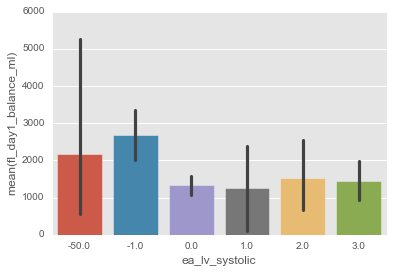

In [10]:
sns.barplot(x='ea_lv_systolic', y='fl_day1_balance_ml', data=ef)
plt.savefig('micu_lvsystolic_day1balance.png')

In [18]:
to_plot = ef[['fl_day1_balance_ml', 'fl_day2_balance_ml', 'fl_day3_balance_ml']].stack().reset_index()
to_plot.columns = ['row_id', 'Day', 'Fluid balance (ml)']
to_plot.loc[to_plot['Day'] == 'fl_day1_balance_ml', 'Day'] = 1
to_plot.loc[to_plot['Day'] == 'fl_day2_balance_ml', 'Day'] = 2
to_plot.loc[to_plot['Day'] == 'fl_day3_balance_ml', 'Day'] = 3
to_plot = to_plot.loc[to_plot['Fluid balance (ml)'] >= -7000]
to_plot = pd.merge(to_plot, ef[['ea_lv_systolic']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['ex_congestive_heart_failure']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['day30_mortality']], left_on='row_id', right_index=True)
to_plot = pd.merge(to_plot, ef[['mech_vent']], left_on='row_id', right_index=True)

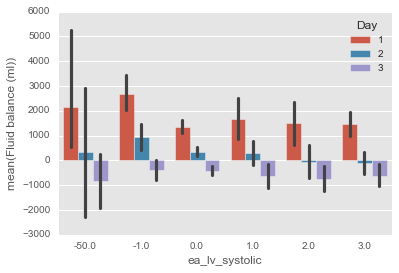

In [19]:
sns.barplot(data = to_plot, x = 'ea_lv_systolic', y = 'Fluid balance (ml)', hue = 'Day')

In [12]:
day30_mortality = ef.ea_days_after_discharge_death <= 30
day30_mortality.value_counts()

False    700
True     526
Name: ea_days_after_discharge_death, dtype: int64

In [13]:
ef['day30_mortality'] = day30_mortality

In [14]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,4,52,378,56,32,58
True,1,62,243,35,30,82


In [15]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table /= table.sum(axis=0)
table ## severely depressed and hyperdynamic have increased likelihood of death

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.8,0.45614,0.608696,0.615385,0.516129,0.414286
True,0.2,0.54386,0.391304,0.384615,0.483871,0.585714


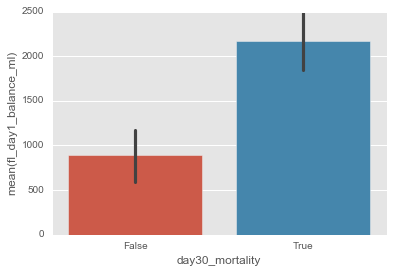

In [23]:
sns.barplot(x='day30_mortality', y='fl_day1_balance_ml', data=ef)

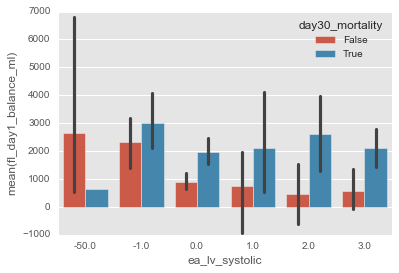

In [29]:
# higher mortality associated with higher fluid balance.
sns.barplot(x='ea_lv_systolic', y='fl_day1_balance_ml', hue = 'day30_mortality', data=ef)
plt.savefig('micu_fluid_mortality.png')

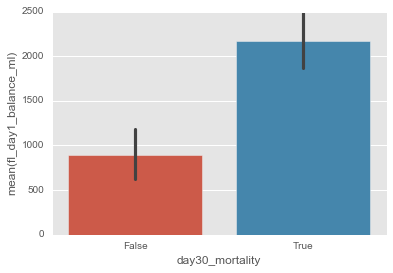

In [20]:
sns.barplot(x='day30_mortality', y='fl_day1_balance_ml', data=ef)

In [25]:
import patsy
ef2 = ef[ef.ea_lv_systolic.isin([-1, 0, 1, 2, 3])]
dta = ef2[['day30_mortality', 'fl_day1_input_ml', 'fl_day1_balance_ml', 'apsiii', 'ea_age', 'gender', 'ea_lv_systolic', 'lab_creatinine', 'lab_hematocrit']].dropna()
dta.describe()#y,X = patsy.dmatrices("day30_mortality ~ apsiii + ea_age + C(gender) + C(ea_lv_systolic) + lab_creatinine + lab_hematocrit", dta, return_type = 'dataframe')
#y,X = patsy.dmatrices("day30_mortality ~ C(ea_lv_systolic) + fl_day1_balance_ml+ C(ea_lv_systolic)*fl_day1_balance_ml+ apsiii + ea_age + C(gender)+ lab_creatinine + lab_hematocrit", dta, return_type = 'dataframe')
y,X = patsy.dmatrices("day30_mortality ~ ea_lv_systolic + fl_day1_balance_ml + ea_lv_systolic*fl_day1_balance_ml+ apsiii + ea_age + C(gender)+ lab_creatinine + lab_hematocrit",dta, return_type = 'dataframe')
X.head()

,Intercept,C(gender)[T.M],ea_lv_systolic,fl_day1_balance_ml,ea_lv_systolic:fl_day1_balance_ml,apsiii,ea_age,lab_creatinine,lab_hematocrit
0,1.0,0.0,3.0,4740.000000,14220.000000,57.0,35.0,1.7,33.7
1,1.0,1.0,1.0,-1564.012497,-1564.012497,50.0,28.0,0.8,43.5
2,1.0,0.0,2.0,5742.809568,11485.619136,103.0,68.0,0.5,40.4
4,1.0,1.0,-1.0,-248.250000,248.250000,43.0,91.6,0.9,31.3
5,1.0,0.0,0.0,-2532.500000,-0.000000,63.0,85.0,1.5,30.6


In [26]:
logit = sm.Logit(y['day30_mortality[True]'],X)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.602389
         Iterations 5
                             Logit Regression Results                            
Dep. Variable:     day30_mortality[True]   No. Observations:                  968
Model:                             Logit   Df Residuals:                      959
Method:                              MLE   Df Model:                            8
Date:                   Thu, 19 Jan 2017   Pseudo R-squ.:                  0.1218
Time:                           15:28:39   Log-Likelihood:                -583.11
converged:                          True   LL-Null:                       -664.00
                                           LLR p-value:                 6.808e-31
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                            -

In [27]:
print result.conf_int()

                                          0         1
Intercept                         -4.658447 -2.463510
C(gender)[T.M]                    -0.046672  0.526918
ea_lv_systolic                    -0.083865  0.189303
fl_day1_balance_ml                -0.000028  0.000064
ea_lv_systolic:fl_day1_balance_ml -0.000006  0.000074
apsiii                             0.026980  0.041716
ea_age                             0.007836  0.024621
lab_creatinine                    -0.140257  0.072164
lab_hematocrit                    -0.029459  0.020137


In [28]:
# logistic regression -- with lv_systolic as categorical variable.
mod3 = smf.glm("day30_mortality ~ C(ea_lv_systolic) + fl_day1_balance_ml+ C(ea_lv_systolic)*fl_day1_balance_ml+ apsiii + ea_age + C(gender)+ lab_creatinine + lab_hematocrit", dta, family=sm.families.Binomial())
gresults = mod3.fit()
print gresults.summary()

                                  Generalized Linear Model Regression Results                                  
Dep. Variable:     ['day30_mortality[False]', 'day30_mortality[True]']   No. Observations:                  968
Model:                                                             GLM   Df Residuals:                      953
Model Family:                                                 Binomial   Df Model:                           14
Link Function:                                                   logit   Scale:                             1.0
Method:                                                           IRLS   Log-Likelihood:                -578.00
Date:                                                 Thu, 19 Jan 2017   Deviance:                       1156.0
Time:                                                         15:31:49   Pearson chi2:                     980.
No. Iterations:                                                      6                                  

In [5]:
# service table lists level of care: https://mimic.physionet.org/mimictables/services/
sql = """SELECT curr_service, count(distinct subject_id) as num_distinct_subject_id
  FROM mimiciii.services
group by curr_service
order by num_distinct_subject_id desc"""
service = pd.read_sql_query(sql, conn)

In [6]:
service

,curr_service,num_distinct_subject_id
0,MED,17778
1,CMED,7949
2,NB,7806
3,CSURG,7443
4,SURG,4571
5,NSURG,3601
6,TRAUM,3068
7,NMED,2672
8,OMED,1455
9,VSURG,1231


In [12]:
# number of patients with servicetype listed as MICU and have echos
sql = """SELECT count(distinct s.subject_id)
  FROM mimiciii.echo_filter_vars as e
  join mimiciii.services as s
  on s.subject_id = e.subject_id and s.hadm_id = e.hadm_id
  where s.curr_service = 'MED'"""
e_s = pd.read_sql_query(sql, conn)
e_s

,count
0,7086


In [16]:
# number of patients with icu location type listed as MICU and have echos
sql = """SELECT count(distinct i.subject_id)
FROM mimiciii.echo_filter_vars as e
  join mimiciii.icustays as i
  on i.subject_id = e.subject_id and i.hadm_id = e.hadm_id
  where i.first_careunit = 'MICU'"""
e_i = pd.read_sql_query(sql, conn)
e_i

,count
0,5758


In [20]:
# a patient can have multiple service types... do i need to identify service type of "MED" with echos taking place near transfertime?  
# take a look at physionet explanation of icustays table and services table.  i am confused... 
sql = """SELECT s.subject_id, s.hadm_id, i.icustay_id, s.transfertime, s.curr_service, i.first_careunit, i.last_careunit, i.first_wardid, i.last_wardid, i.intime, i.outtime, i.los
  FROM mimiciii.services as s
  join mimiciii.icustays as i
  on s.subject_id = i.subject_id and s.hadm_id = i.hadm_id
  where curr_service = 'MED'
  order by s.subject_Id, s.hadm_id, i.icustay_id, s.transfertime"""
serv_icustay = pd.read_sql_query(sql, conn)

In [31]:
# interesting subject_ids:
df = serv_icustay[serv_icustay['subject_id']==91]
#df[df['A'] > 0]

In [33]:
df.head()

,subject_id,hadm_id,icustay_id,transfertime,curr_service,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,91,145834,211552,2101-10-26 20:43:42,MED,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
1,91,185777,294638,2191-03-16 00:29:31,MED,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
2,91,188822,298129,2167-10-02 11:20:39,MED,CCU,CCU,7,7,2167-10-02 11:20:39,2167-10-03 18:16:05,1.2885
3,91,111970,216859,2135-01-30 20:53:34,MED,MICU,MICU,52,52,2135-01-30 20:53:34,2135-02-08 05:38:46,8.3647
4,91,165315,204798,2196-04-09 12:27:00,MED,MICU,MICU,52,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438
